# ДЗ 1
## Корепанов Алексей, МОиАД 
### 17.10.2020

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize_scalar

import warnings
warnings.filterwarnings("ignore")

Был написан алгоритм Брента с использованием производных

In [15]:
def optimize(f, a: float, b: float, eps: float = 1e-8, analyze=False):
    x = w = v = (a + b) / 2 # x - текущий минимум, w - второй текущий мининмум, v - третий текущий минимум 
    fx, dfx = f(x) # Вызываем функцию 1 раз
    fw = fv = fx # Значения функции в x, w, v
    dfw = dfv = dfx # Их производные
    d = e = b - a # Шаг на этом шаге, шаг на предыдущем шаге

    result_dict = {
        'values': [],
        'nit': 0,
        'x': x,
        'fx': fx
        }

    niter = 1000
    
    for i in range(niter):
        tol = eps * abs(x) + eps / 10

        if abs(x - (a + b) / 2) <= 2 * tol - + 0.5 * (b - a):
            break

        bisect = False

        if abs(e) > tol:
            d1 = d2 = 2 * (b - a)

            # Строим 2 параболы - по dfw, dfx, w, v и по dfv, dfx, v, x
            if dfw != dfx:
                d1 = (w - x) * dfx / (dfx - dfw)
            if dfv != dfx:
                d2 = (v - x) * dfx / (dfx - dfv)

            u1 = x + d1 # Минимум 1ой параболы
            u2 = x + d2 # Минимум 2ой параболы

            # Входят ли эти параболы в промежуток [a; b] и ведут ли они в сторону уменьшения функции
            u1_fine = a <= u1 <= b and d1 * dfx <= 0 # Подходит ли 1ая парабола
            u2_fine = a <= u2 <= b and d2 * dfx <= 0 # Подходит ли 2ая парабола

            priv_e = e # Предпердыдущий шаг
            e = d

            # Есть ли парабола, которая подходит условиям
            if u1_fine or u2_fine:
                if u1_fine and u2_fine:
                    d = d1 if abs(d1) < abs(d2) else d2
                else:
                    d = d1 if u1_fine else d2

                # Уменьшился ли промежуток по сравнению с предпредыдущим шагом в 2 раза
                if abs(d) < abs(0.5 * priv_e):
                    u = x + d
                    
                    # Если слишком близко к краям
                    if u - a < 2 * tol or b - u < 2 * tol:
                        if (a + b) / 2 - x >= 0:
                            d = abs(tol)
                        else:
                            d = -abs(tol)
                else:
                    bisect = True
            else:
                bisect = True
        else:
            bisect = True

        if bisect:
            e = a - x if dfx >= 0 else b - x           
            d = 0.5 * e

        # Если все плохо и параболы не подходят по какому-то условию, то просто делим отрезок пополам
        
        # Если шаг больше минимального
        if abs(d) >= tol:
            u = x + d
            fu, dfu = f(u)
        else:
            # Иначе шаг равен минимальному
            u = x + tol if d >= 0 else x - tol
            fu, dfu = f(u)

            # Если шаг уже минимален, то он уже не уменьшится, но f(u) стало больше f(x),
            # то продолжать дальше не имеет смысла
            if fu > fx:
                break

        # Выставляем в нужном порядке
        if fu <= fx:
            if u >= x:
                a = x
            else:
                b = x
            v, w, x = w, x, u
            fv, fw, fx = fw, fx, fu
            dfv, dfw, dfx = dfw, dfx, dfu
        else:
            if u >= x:
                b = u
            else:
                a = u
            if fu <= fw or w == x:
                v, w = w, u
                fv, fw = fw, fu
                dfv, dfw = dfw, dfu
            elif fu < fv or v == x or v == w:
                v = u
                fv = fu
                dfv = dfu

        result_dict['values'].append(x)

    result_dict['x'] = x
    result_dict['fx'] = fx
    result_dict['nit'] = i

    if analyze:
        return result_dict
    else:
        return x

Проверим на самой простой функции:

In [16]:
optimize(lambda x: ((x - 2) ** 2, 2 * (x - 2)), -10, 10)

2.0

Добавим функцию для тестирования и просмотра графиков функций. Также будем сравнивать со скайпаевской функцией.

In [21]:
def optimize_scipy(f, a: float, b: float, eps: float = 1e-8):
    return minimize_scalar(lambda x: f(x)[0], bracket=(a, b), tol=eps)


def test(f, bounds, title):
    results_scipy = optimize_scipy(f, bounds[0], bounds[1])
    true_min = results_scipy['x']
    results = optimize(f, bounds[0], bounds[1], analyze=True) 

    x_1 = np.linspace(bounds[0], bounds[1], 100)
    y_1 = []
    for i in x_1:
        y_1.append(f(i)[0])

    x_2 = list(range(1, results['nit'] + 1))
    y_2 = np.log(abs(np.array(results['values']) - true_min) + 1)

    fig, axis = plt.subplots(1, 2, figsize=(16, 4))
    axis[0].plot(x_1, y_1, 'r')
    axis[0].set_title(title + ' plot')
    axis[1].plot(x_2, y_2, 'g')
    axis[1].set_title(title + ' accuracy')

    plt.show()

    print(f"Scipy    - x: {results_scipy['x']}, nit: {results_scipy['nit']}")
    print(f"Optimize - x: {results['x']}, nit: {results['nit']}")

Посмотрим на работу алгоритма на наборе унимодальных функций

In [22]:
def problem_1(x):
    return -(16 * x ** 2 - 24 * x + 5) * np.e ** (-x), (16 * x ** 2 - 56 * x + 29) * np.e ** (-x)

def problem_2(x):
    return -(x + np.sin(x)) * np.e ** (-x ** 2), -2 * x * (-x - np.sin(x)) * np.e ** (-x ** 2) + (-np.cos(x) - 1) * np.e ** (-x ** 2)

def problem_3(x):
    return (x ** 2 - 5 * x + 6) / (x ** 2 + 1), 5 * (x ** 2 - 2 * x - 1) / (x ** 2 + 1) ** 2 

def problem_4(x):
    if x <= 3:
        return (x - 2) ** 2, 2 * (x - 2)

    return 2 * np.log(x - 2) + 1, 2 / (x - 2)

def problem_5(x):
    return -(x - np.sin(x)) * np.e ** (-x ** 2),  -2 * x * (-x + np.sin(x)) * np.e ** (-x ** 2) + (np.cos(x) - 1) * np.e ** (-x ** 2) 

In [23]:
problems = [
            problem_1, 
            problem_2,
            problem_3,
            problem_4,
            problem_5
            ]
bounds = {
    problem_1: (1.9, 3.9),
    problem_2: (-10, 10),
    problem_3: (-5, 5),
    problem_4: (0, 6),
    problem_5: (-9, 10)
}

Посмотрим на результат для унимодальных функций по сравнению с обычным
методом Брента.

-------------------------------------------------- Problem 1 --------------------------------------------------


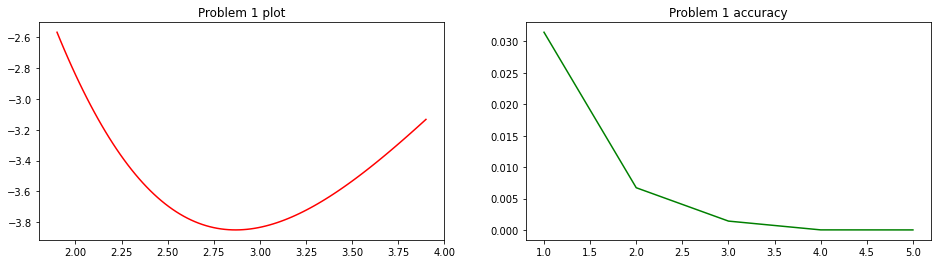

Scipy    - x: 2.8680339885378094, nit: 11
Optimize - x: 2.8680339928316108, nit: 5
-------------------------------------------------- Problem 2 --------------------------------------------------


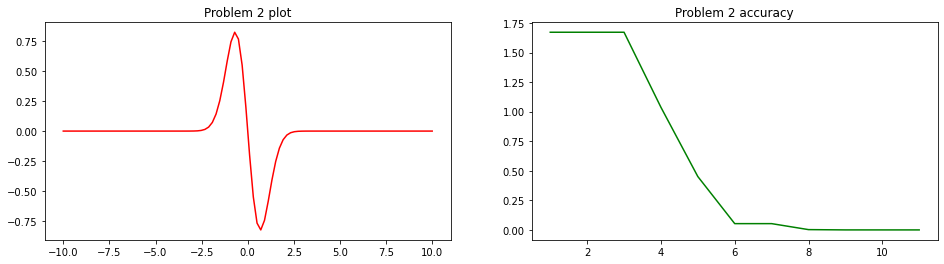

Scipy    - x: 0.6795786661339362, nit: 17
Optimize - x: 0.6795786598008219, nit: 11
-------------------------------------------------- Problem 3 --------------------------------------------------


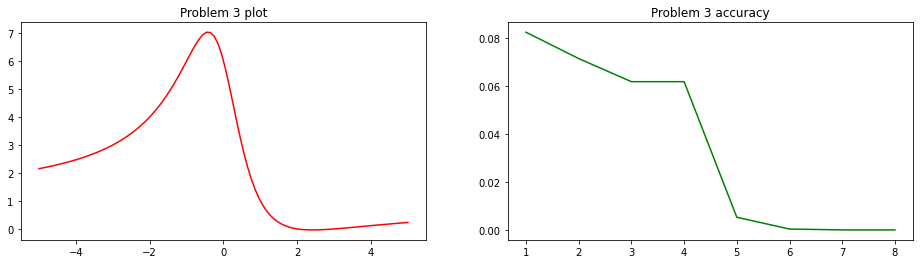

Scipy    - x: 2.414213588068461, nit: 15
Optimize - x: 2.4142135737630617, nit: 8
-------------------------------------------------- Problem 4 --------------------------------------------------


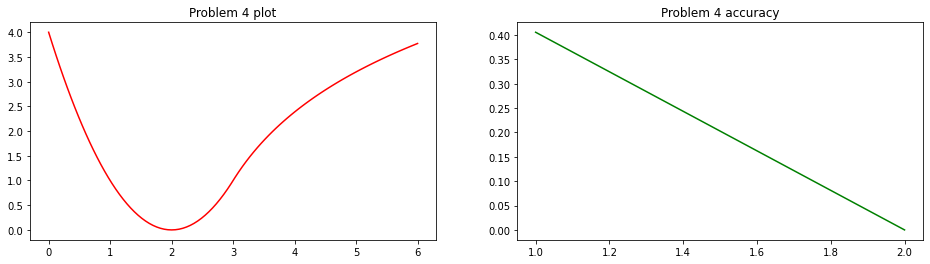

Scipy    - x: 2.0, nit: 8
Optimize - x: 2.0, nit: 2
-------------------------------------------------- Problem 5 --------------------------------------------------


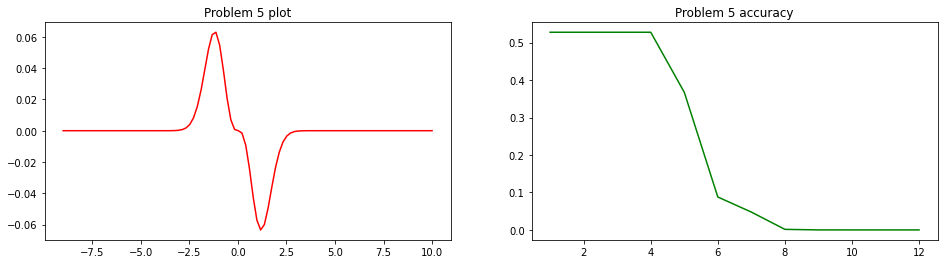

Scipy    - x: 1.1951366468365627, nit: 17
Optimize - x: 1.1951366417569598, nit: 12


In [24]:
for i, problem in enumerate(problems):
    print(f"{'-' * 50} Problem {i + 1} {'-' * 50}")
    test(problem, bounds[problem], f'Problem {i + 1}')

Видим, что все функции считаются быстрее, чем при использовании обычного метода Брента.

Посмотрим теперь на работу метода на неунимодальных функциях.

In [25]:
def problem_6(x):
    return np.sin(x), np.cos(x) 

def problem_7(x):
    return np.sin(x) ** 3 + np.cos(x) ** 3, 3 * np.sin(x) ** 3 * np.cos(x) - 3 * np.sin(x) * np.cos(x) ** 2

def problem_8(x):
    return -(x - np.sin(x)) * np.e ** (-x ** 2),  -2 * x * (-x + np.sin(x)) * np.e ** (-x ** 2) + (np.cos(x) - 1) * np.e ** (-x ** 2) 

def problem_9(x):
    return x * np.sin(x) + x * np.cos(2 * x), -2 * x * np.sin(2 * x) + x * np.cos(x) + np.sin(x) + np.cos(2 * x)

def problem_10(x):
    return -(-2 * x ** 4 + 2 * x ** 3 - 16 * x ** 2 - 60 * x + 100), 8 * x ** 3 - 6 * x ** 2 + 32 * x + 60

def problem_11(x):
    if x == 0:
        return 0, 0
    
    return (x - 2/3) ** (-1), -1 / (x - 2/3) ** 2

def problem_12(x):
    if x <= 1/3:
        return -10 ** (-3), 0
    
    return (x - 1/3) - 10 ** (-3), 1

In [26]:
problems = [
            problem_6, 
            problem_7,
            problem_8,
            problem_9,
            problem_10,
            problem_11,
            problem_12
            ]
bounds = {
    problem_6: (-10, 10),
    problem_7: (-10, 10),
    problem_8: (0, 6),
    problem_9: (-2, 10),
    problem_10: (0, 10),
    problem_11: [-50, 6],
    problem_12: [-10, 10],
}

-------------------------------------------------- Problem 6 --------------------------------------------------


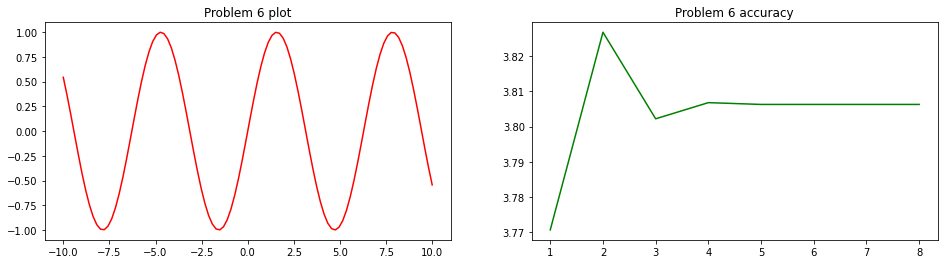

Scipy    - x: 42.411500823405156, nit: 18
Optimize - x: -1.5707963197653878, nit: 8
-------------------------------------------------- Problem 7 --------------------------------------------------


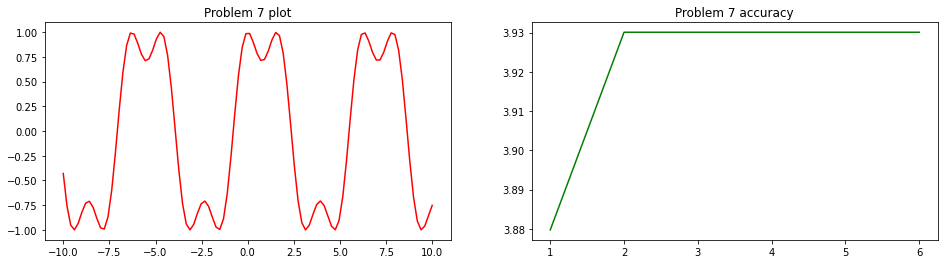

Scipy    - x: 42.411500760431124, nit: 17
Optimize - x: -7.500000076, nit: 6
-------------------------------------------------- Problem 8 --------------------------------------------------


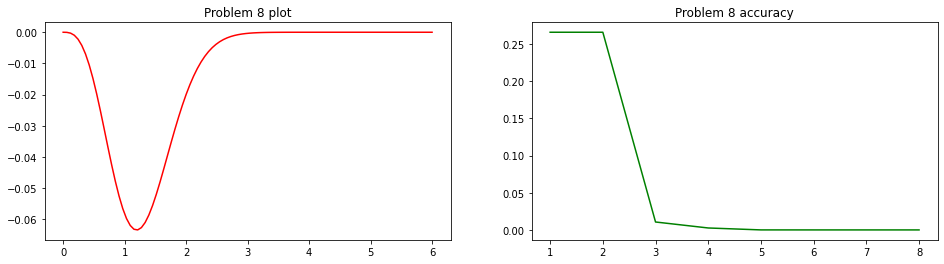

Scipy    - x: 1.1951366343232848, nit: 13
Optimize - x: 1.1951366417708156, nit: 8
-------------------------------------------------- Problem 9 --------------------------------------------------


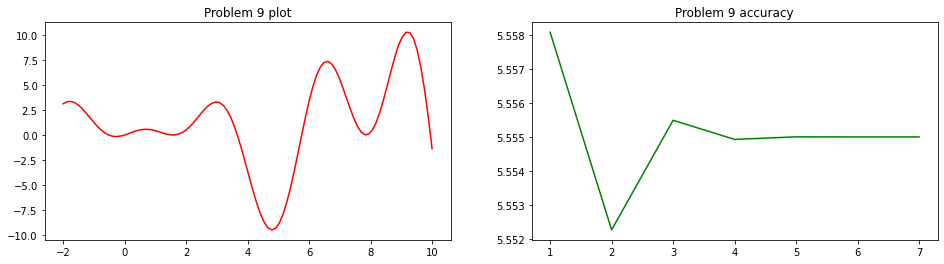

Scipy    - x: 262.3245114054398, nit: 16
Optimize - x: 4.795408682001029, nit: 7
-------------------------------------------------- Problem 10 --------------------------------------------------


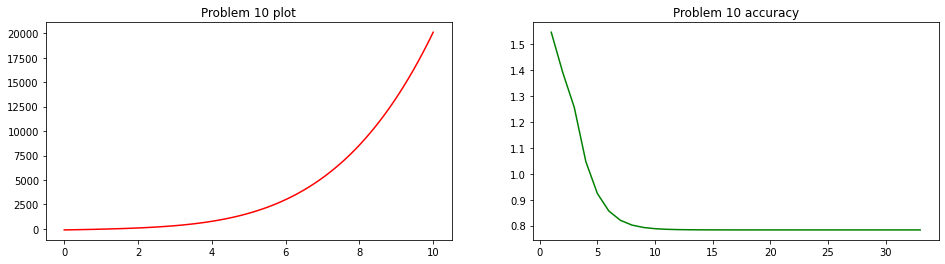

Scipy    - x: -1.1892787831614142, nit: 16
Optimize - x: 1.2285139134104398e-09, nit: 33
-------------------------------------------------- Problem 11 --------------------------------------------------


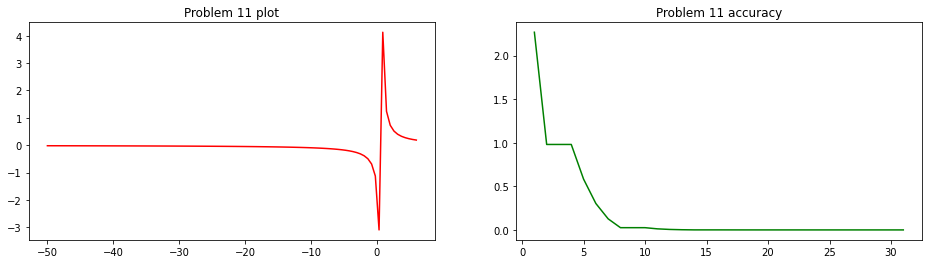

Scipy    - x: 0.6666666586103751, nit: 48
Optimize - x: 0.6666666585952044, nit: 31
-------------------------------------------------- Problem 12 --------------------------------------------------


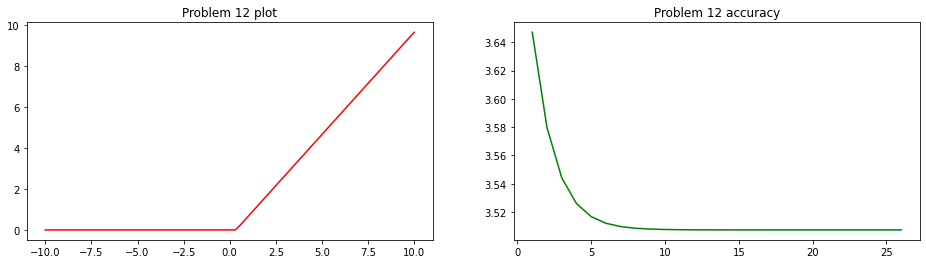

Scipy    - x: -42.360679454306386, nit: 37
Optimize - x: -9.999999850988388, nit: 26


In [27]:
for i, problem in enumerate(problems):
    print(f"{'-' * 50} Problem {i + 6} {'-' * 50}")
    test(problem, bounds[problem], f'Problem {i + 6}')

Видим, что на функциях с минимумами метод сходится в локальный минимум, даже правильней, чем scipy, и быстрей. На функции без явного минимума метод может сходится дольше и результат может быть иногда в диапазоне a <= b, но может быть непредсказуемым.